In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from nixtla.experiments.utils import *
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from nixtla.losses.numpy import mae, mape, smape, rmse, pinball_loss
from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader

In [2]:
def evaluate_horizon(horizon, data, n_trials, feature):    
    nbeats_space= {# Architecture parameters
                'model':'nbeats',
                'input_size_multiplier': hp.choice('input_size_multiplier', [1, 2, 3, 4, 5]),
                'output_size': hp.choice('output_size', [horizon]),
                'shared_weights': hp.choice('shared_weights', [False]),
                'activation': hp.choice('activation', ['relu','selu']),
                'initialization':  hp.choice('initialization', ['glorot_normal','he_normal']),
                'stack_types': hp.choice('stack_types', [ ['trend', 'seasonality'] ]),
                'n_blocks': hp.choice('n_blocks', [ [3, 3] ]),
                'n_layers': hp.choice('n_layers', [ 6*[2] ]),
                'n_hidden': hp.choice('n_hidden', [ 256, 512 ]),
                'n_harmonics': hp.choice('n_harmonics', [1, 2]),
                'n_polynomials': hp.choice('n_polynomials', [2, 4]),
                'exogenous_n_channels': hp.quniform('exogenous_n_channels', 1, 10, 1),
                'x_s_n_hidden': hp.choice('x_s_n_hidden', [0]),
                # Regularization and optimization parameters
                'batch_normalization': hp.choice('batch_normalization', [False, True]),
                'dropout_prob_theta': hp.uniform('dropout_prob_theta', 0, 0.5),
                'dropout_prob_exogenous': hp.uniform('dropout_prob_exogenous', 0, 0.5),
                'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.001)),
                'lr_decay': hp.uniform('lr_decay', 0.3, 0.5),
                'n_lr_decay_steps': hp.choice('n_lr_decay_steps', [3]),
                'weight_decay': hp.loguniform('weight_decay', np.log(5e-5), np.log(5e-3)),
                'n_iterations': hp.choice('n_iterations', [1_000]), #[args.max_epochs]),
                'early_stopping': hp.choice('early_stopping', [10]),
                'eval_freq': hp.choice('eval_freq', [50]),
                'n_val_weeks': hp.choice('n_val_weeks', [52*2]),
                'loss': hp.choice('loss', ['MAE', 'MSE']),
                'loss_hypar': hp.choice('loss_hypar', [0.5]),                
                'val_loss': hp.choice('val_loss', ['MAE']), #[args.val_loss]),
                'l1_theta': hp.choice('l1_theta', [0]),
                # Data parameters
                'len_sample_chunks': hp.choice('len_sample_chunks', [None]),
                'normalizer_y': hp.choice('normalizer_y', [None]),
                'normalizer_x': hp.choice('normalizer_x', [None]),
                'window_sampling_limit': hp.choice('window_sampling_limit', [100_000]),
                'complete_inputs': hp.choice('complete_inputs', [True]),
                'complete_sample': hp.choice('complete_sample', [True]),                
                'frequency': hp.choice('frequency', ['H']),
                'seasonality': hp.choice('seasonality', [24]),      
                'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [1]),
                'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [1]),
                'batch_size': hp.choice('batch_size', [256]),
                'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
                'random_seed': hp.quniform('random_seed', 10, 20, 1)}
                
    Y_df = data[['unique_id','ds', feature]]
    Y_df = Y_df.sort_values(['unique_id','ds']).reset_index(drop=True)
    Y_df = Y_df.rename(columns={feature:'y'})
    Y_df['ds'] = np.tile(np.array(range(10000)), 14)
    Y_train_df = Y_df[Y_df['ds']<10000-horizon].reset_index(drop=True)
    Y_train_df['ds'] = pd.to_datetime(Y_train_df['ds'])
    Y_df['ds'] = pd.to_datetime(Y_df['ds'])

    trials = hyperopt_tunning(space=nbeats_space, hyperopt_iters=n_trials, loss_function=mae, Y_df=Y_train_df, X_df=None, S_df=None,
                            ds_in_test=horizon, shuffle_outsample=False)

    # Best mc
    mc = trials.trials[np.argmin(trials.losses())]['result']['mc']

    # Model
    final_nbeats = instantiate_nbeats(mc)

    # Datasets
    # Train and val
    train_ts_dataset, validation_ts_dataset, scaler_y = create_datasets(mc=mc, Y_df=Y_train_df, X_df=None, S_df=None, ds_in_test=horizon,                                                                                 shuffle_outsample=False)
    # Test
    test_mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=horizon, is_test=True)
    test_ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=None, S_df=None, mask_df=test_mask_df, verbose=True)

    # Loaders
    # Train and val
    train_ts_loader, val_ts_loader = instantiate_loaders(mc=mc, train_ts_dataset=train_ts_dataset, outsample_ts_dataset=validation_ts_dataset)
    # Test
    test_ts_loader = TimeSeriesLoader(ts_dataset=test_ts_dataset,
                                    model=mc['model'],
                                    window_sampling_limit=int(mc['window_sampling_limit']),
                                    input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                    output_size=int(mc['output_size']),
                                    idx_to_sample_freq=mc['val_idx_to_sample_freq'],
                                    len_sample_chunks=mc['len_sample_chunks'],
                                    batch_size=1,
                                    n_series_per_batch=mc['n_series_per_batch'],
                                    complete_inputs=mc['complete_inputs'],
                                    complete_sample=mc['complete_sample'],
                                    shuffle=False)

    # Val loader not implemented during training for ESRNN and RNN
    final_nbeats.fit(train_ts_loader=train_ts_loader, val_ts_loader=val_ts_loader, verbose=True,
                    eval_freq=mc['eval_freq'])

    y_true_test, y_hat_test, mask_test = final_nbeats.predict(ts_loader=test_ts_loader, return_decomposition=False)

    test_mae = mae(y_true_test, y_hat_test)
    test_rmse = rmse(y_true_test, y_hat_test)

    fig, ax = plt.subplots(nrows=3, ncols=4, figsize = (15,10))
    for i in range(12):
        ax[i//4, i%4].plot(y_true_test[i,0,:])
        ax[i//4, i%4].plot(y_hat_test[i,0,:])
        ax[i//4, i%4].grid(True)
        ax[i//4, i%4].set_xlabel('Timestamp')
        ax[i//4, i%4].set_ylabel('ART')
        ax[i//4, i%4].set_title(f'Patient {i}')
    plt.tight_layout()
    plt.savefig(f'{feature}_{horizon}.pdf')

    return test_mae, test_rmse

In [3]:
data = pd.read_csv('../data/healthcare/data_waveforms_icu.csv')
data.head()

,unique_id,ds,ART,PLETH
0,20200220_1931349_1731786,56591.142942,125.8125,0.564835
1,20200220_1931349_1731786,56591.150942,124.5625,0.558974
2,20200220_1931349_1731786,56591.158942,124.5000,0.552869
3,20200220_1931349_1731786,56591.166942,124.7500,0.547985
4,20200220_1931349_1731786,56591.174942,124.5000,0.542857


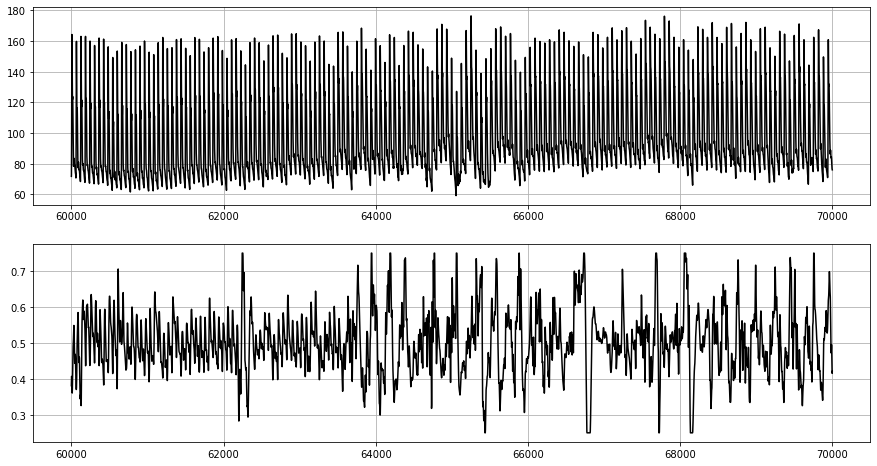

In [4]:
unique_patients = data.unique_id.unique()
patient_id = 6
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (15,8))
ax[0].plot(data[data['unique_id']==unique_patients[patient_id]]['ART'], c='black')
ax[0].grid()
ax[1].plot(data[data['unique_id']==unique_patients[patient_id]]['PLETH'], c='black')
ax[1].grid(True)

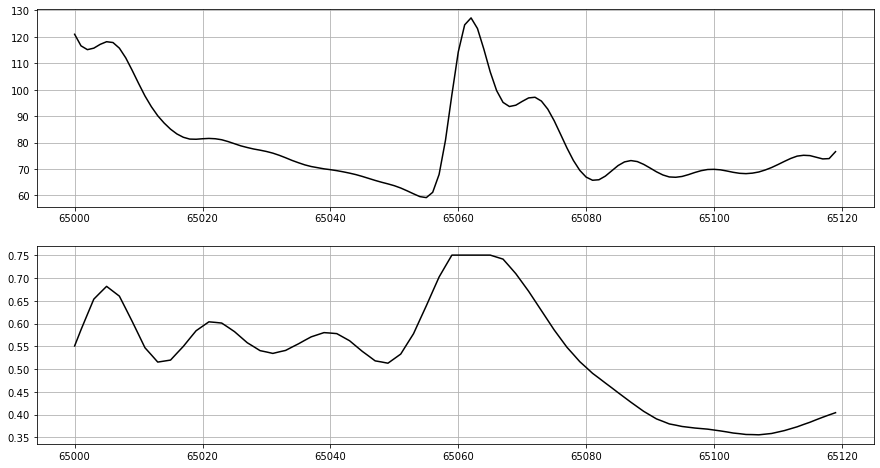

In [5]:
unique_patients = data.unique_id.unique()
patient_id = 6
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (15,8))
ax[0].plot(data[data['unique_id']==unique_patients[patient_id]]['ART'][5000:5120], c='black')
ax[0].grid()
ax[1].plot(data[data['unique_id']==unique_patients[patient_id]]['PLETH'][5000:5120], c='black')
ax[1].grid(True)

In [6]:
test_maes = []
test_rmses = []
horizons = [60] #[15, 30, 60, 120, 240, 480, 960]
for horizon in horizons:
    print(100*'-')
    print('HORIZON: ', horizon)
    test_mae, test_rmse = evaluate_horizon(horizon=horizon, data=data, n_trials=10, feature='PLETH')
    test_maes.append(test_mae)
    test_rmses.append(test_rmse)

----------------------------------------------------------------------------------------------------
HORIZON:  60
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]WARNING:root:Batch size will be ignored (shuffle=False). All windows constructed will be used to train.

============================== Start fitting ==============================
Step: 50, Time: 4.636, Insample MSE: 0.04437, Outsample MAE: 0.08372
Step: 100, Time: 11.617, Insample MSE: 0.01110, Outsample MAE: 0.05781
Step: 150, Time: 18.486, Insample MSE: 0.01396, Outsample MAE: 0.06370
Step: 200, Time: 25.380, Insample MSE: 0.00861, Outsample MAE: 0.06008
Step: 250, Time: 32.269, Insample MSE: 0.01015, Outsample MAE: 0.05816
Step: 300, Time: 39.205, Insample MSE: 0.00445, Outsample MAE: 0.05572
Step: 350, Time: 46.095, Insample MSE: 0.00882, Outsample MAE: 0.05924
  0%|          | 0/10 [00:49<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

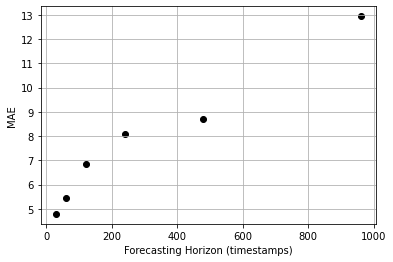

In [74]:
hola = pickle.load(open('result_ART_20210329.p','rb'))
plt.scatter(np.array(hola['horizons'])[[1,2,3,4,5,6]], np.array(hola['mae'])[[1,2,3,4,5,6]], c='black')
plt.xlabel('Forecasting Horizon (timestamps)')
plt.ylabel('MAE')
plt.grid()
plt.savefig('horizon_vs_mae.pdf')

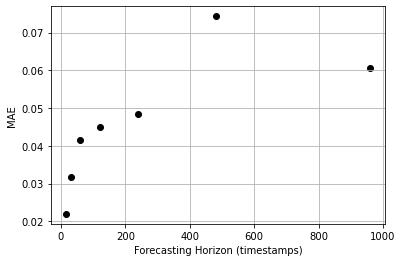

In [75]:
hola = pickle.load(open('result_PLETH_20210329.p','rb'))

y_hat = hola['y_hat']
y_true = hola['y_true']
horizons = hola['horizons']
maes = hola['mae']

plt.scatter(horizons, maes, c='black')
plt.xlabel('Forecasting Horizon (timestamps)')
plt.ylabel('MAE')
plt.grid()
plt.savefig('horizon_vs_mae_pleth.pdf')